# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Колво пропусков
df.isnull().sum().sort_values(ascending=False)
# Пропуски есть только в столбце balance их 25

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

In [4]:
df['job'].value_counts()
# unknown по сути тоже является пропуском

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [5]:
df['balance'].value_counts()
df_copy = df.copy()
# df_copy = df_copy.dropna()
df_copy['balance'] = df_copy['balance'].apply(lambda x: x[:-2].replace(',', '.').replace(' ', '') if pd.notna(x) else x)
df_copy['balance'] = df_copy['balance'].astype(float)
df_copy['balance'].mean()

1529.1290293615875

In [6]:
# Пропуски в balance удалять не буду, заменю на медианное значение признака
df_copy['balance'] = df_copy['balance'].fillna(df_copy['balance'].median())
df_copy['balance'].mean()

1526.9360329690019

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df_copy.loc[df_copy['education'] == 'unknown', 'education'] = df_copy['education'].mode()[0]
df_copy.loc[df_copy['job'] == 'unknown', 'job'] = df_copy['job'].mode()[0]

df_copy[(df_copy['education'] == df_copy['education'].mode()[0]) & (df_copy['job'] == df_copy['job'].mode()[0])]['balance'].mean()

1598.8829787234042

In [8]:
# удалите все выбросы для признака balance
# метод тьюки
Q_25 = df_copy['balance'].quantile(0.25)
Q_75 = df_copy['balance'].quantile(0.75)
print(Q_25, Q_75)
IQR = Q_75 - Q_25
lower = Q_25 - 1.5 * IQR
upper = Q_75 + 1.5 * IQR
print(lower, upper)
df_copy = df_copy[(df_copy['balance'] >= lower) & (df_copy['balance'] <= upper)] 
df_copy.shape

123.0 1699.0
-2241.0 4063.0


(10105, 17)

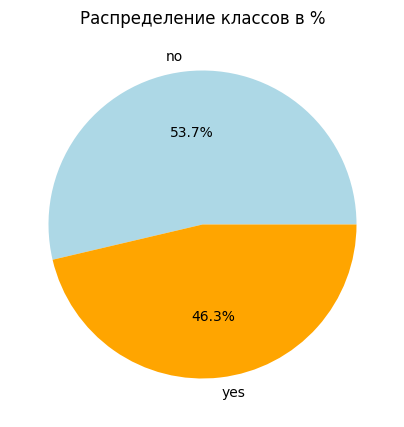

In [9]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df_copy['deposit'].value_counts(normalize=True)
# plt.figure(figsize=(6, 4))
# sns.countplot(x=df_copy['deposit'])
# plt.title('Распределение классов в целевой переменной')
# plt.xlabel('deposit')
# plt.ylabel('Количество')
# plt.show()

df_copy['deposit'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', colors=['lightblue', 'orange'], figsize=(5, 5))
plt.title('Распределение классов в %')
plt.ylabel('')
plt.show()




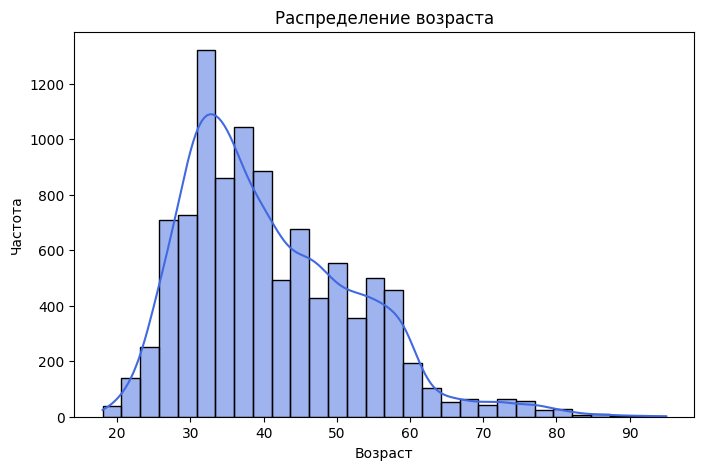

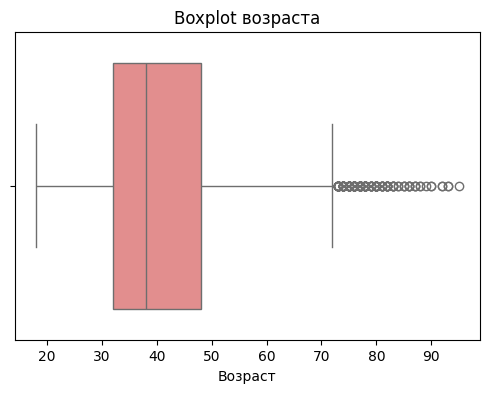

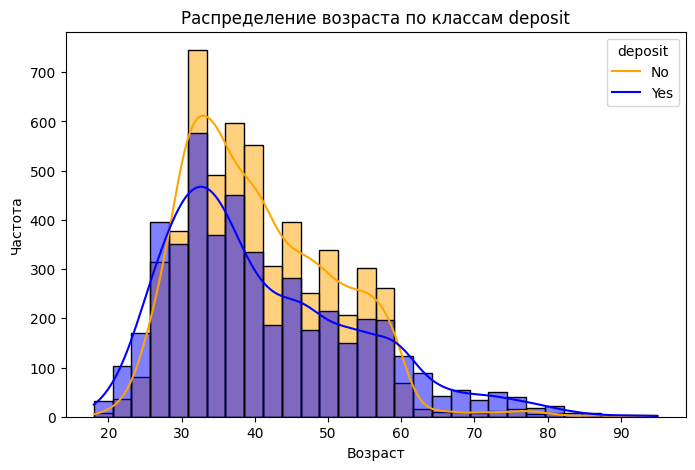

In [10]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df_copy['age'].max()
plt.figure(figsize=(8, 5))
sns.histplot(df_copy['age'], bins=30, kde=True, color='royalblue')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_copy['age'], color='lightcoral')
plt.title('Boxplot возраста')
plt.xlabel('Возраст')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=df_copy, x='age', hue='deposit', bins=30, kde=True, palette=['blue', 'orange'])
plt.title('Распределение возраста по классам deposit')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.legend(title='deposit', labels=['No', 'Yes'])
plt.show()


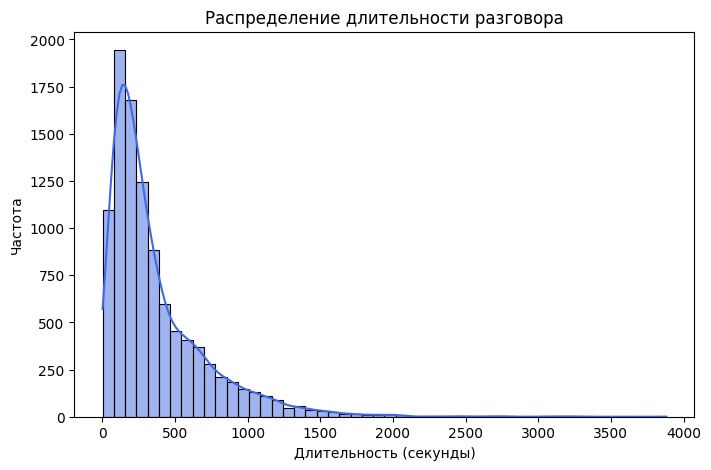

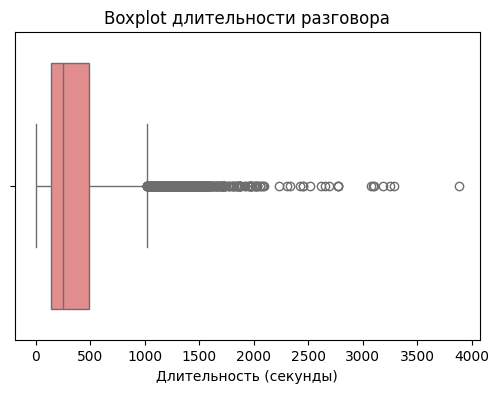

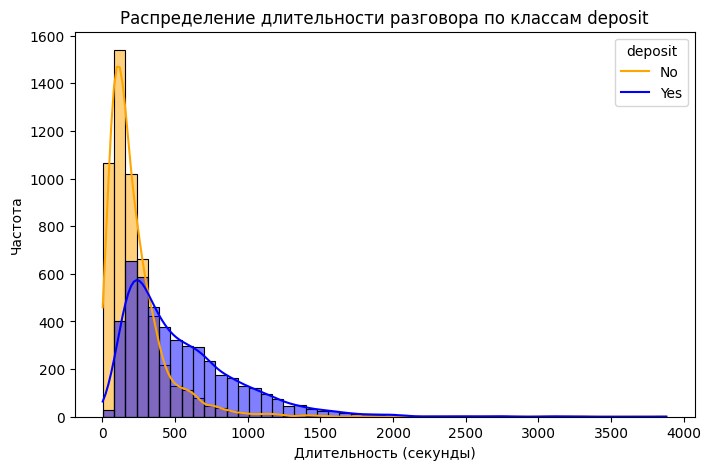

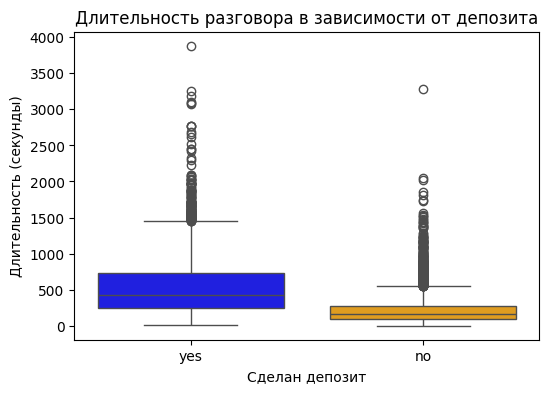

In [11]:
# разговор с клиентом банка 
df_copy['duration'].min()

plt.figure(figsize=(8, 5))
sns.histplot(df_copy['duration'], bins=50, kde=True, color='royalblue')
plt.title('Распределение длительности разговора')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=df_copy['duration'], color='lightcoral')
plt.title('Boxplot длительности разговора')
plt.xlabel('Длительность (секунды)')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data=df_copy, x='duration', hue='deposit', bins=50, kde=True, palette=['blue', 'orange'])
plt.title('Распределение длительности разговора по классам deposit')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Частота')
plt.legend(title='deposit', labels=['No', 'Yes'])
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='deposit', y='duration', data=df_copy, palette=['blue', 'orange'])
plt.title('Длительность разговора в зависимости от депозита')
plt.xlabel('Сделан депозит')
plt.ylabel('Длительность (секунды)')
plt.show()


In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [13]:
# Выведем общую информацию о категориальных переменных
categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"Столбец: {col}")
    print(df_copy[col].value_counts()[:3])  # Частота встречаемости
    print(f"Уникальные значения: {df_copy[col].nunique()}")  # Количество уникальных значений
    print(f"Мода: {df_copy[col].mode()[0]}")  # Самое частое значение
    print("-" * 40)


Столбец: job
job
management     2315
blue-collar    1807
technician     1638
Name: count, dtype: int64
Уникальные значения: 11
Мода: management
----------------------------------------
Столбец: marital
marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64
Уникальные значения: 3
Мода: married
----------------------------------------
Столбец: education
education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64
Уникальные значения: 3
Мода: secondary
----------------------------------------
Столбец: default
default
no     9939
yes     166
Name: count, dtype: int64
Уникальные значения: 2
Мода: no
----------------------------------------
Столбец: housing
housing
no     5243
yes    4862
Name: count, dtype: int64
Уникальные значения: 2
Мода: no
----------------------------------------
Столбец: loan
loan
no     8712
yes    1393
Name: count, dtype: int64
Уникальные значения: 2
Мода: no
----------------------------------------
Столбец:

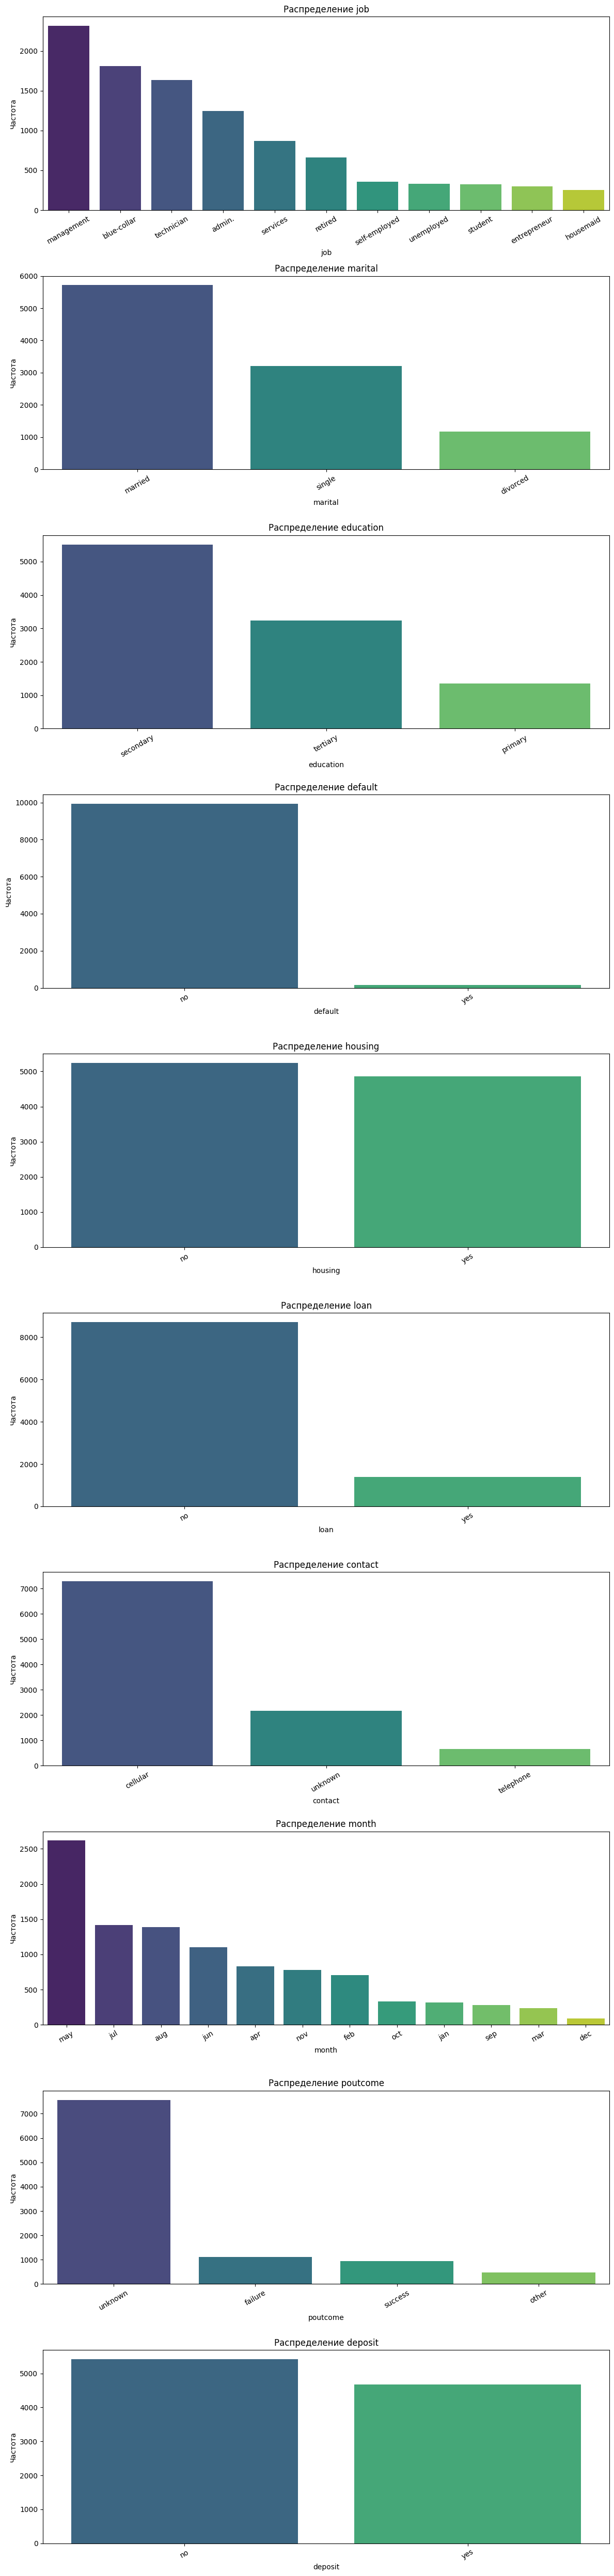

In [14]:
plt.figure(figsize=(12, 5 * len(categorical_cols)))  # Автоматическая высота
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(data=df_copy, x=col, order=df_copy[col].value_counts().index, palette='viridis')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


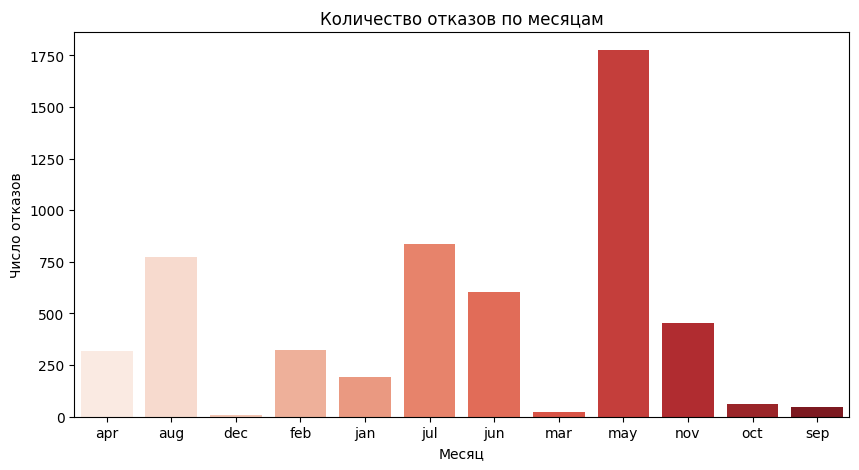

In [ ]:
# ваш код
monthly_counts = df_copy.groupby('month')['deposit'].value_counts().unstack()

# Отдельно считаем количество отказов ('no')
monthly_counts['total'] = monthly_counts.sum(axis=1)
monthly_counts['rejection_rate'] = monthly_counts['no'] / monthly_counts['total'] * 100

# Столбчатая диаграмма отказов
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts.index, y=monthly_counts['no'], palette='Reds')
plt.title('Количество отказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число отказов')
plt.show()


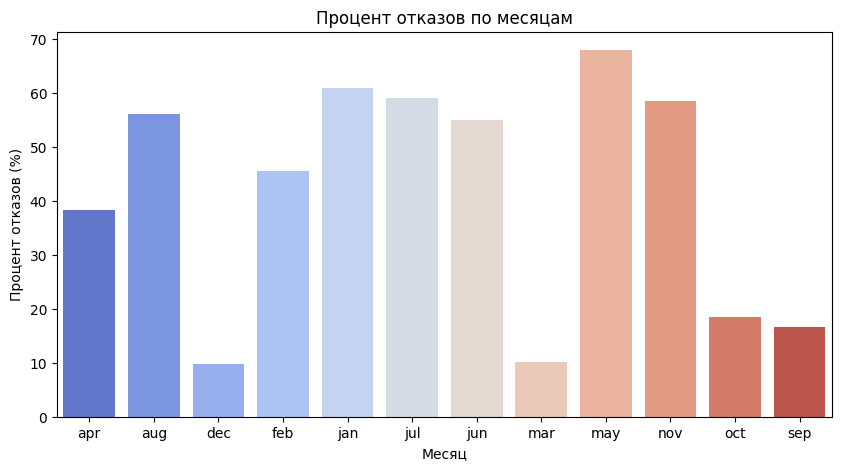

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts.index, y=monthly_counts['rejection_rate'], palette='coolwarm')
plt.title('Процент отказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Процент отказов (%)')
plt.show()


<Figure size 1000x600 with 0 Axes>

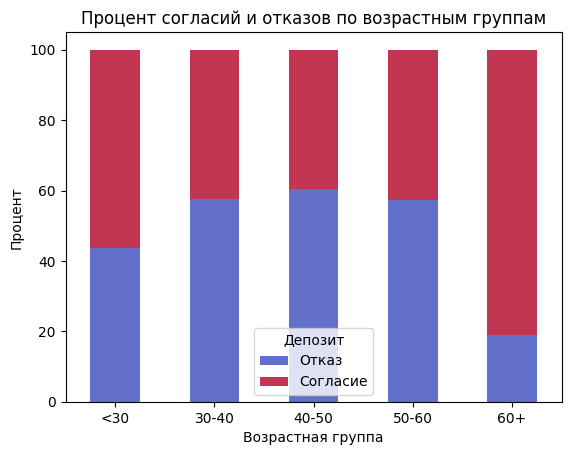

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Определяем категории возраста
bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['<30', '30-40', '40-50', '50-60', '60+']
df_copy['age_group'] = pd.cut(df_copy['age'], bins=bins, labels=labels)
# Группировка по возрастным категориям
age_deposit_counts = df_copy.groupby('age_group')['deposit'].value_counts(normalize=True).unstack() * 100

# График распределения по группам
plt.figure(figsize=(10, 6))
age_deposit_counts.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.8)
plt.title('Процент согласий и отказов по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент')
plt.legend(title='Депозит', labels=['Отказ', 'Согласие'])
plt.xticks(rotation=0)
plt.show()


In [18]:
df_copy.drop('age_group', axis=1, inplace=True)
df_copy.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

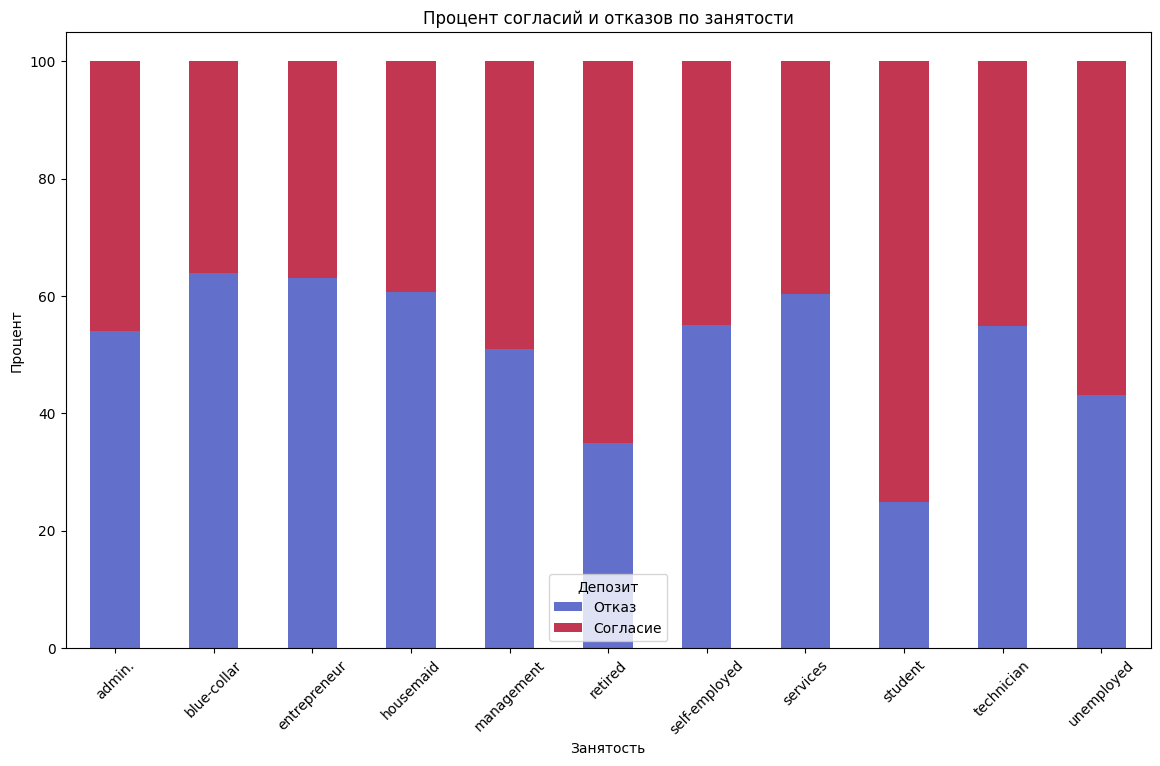

In [ ]:
age_deposit_counts = df_copy.groupby('job')['deposit'].value_counts(normalize=True).unstack() * 100

# График распределения по группам
fig, ax = plt.subplots(figsize=(14, 8))  # Увеличиваем размер
age_deposit_counts.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.8, ax=ax)
ax.set_title('Процент согласий и отказов по занятости')
ax.set_xlabel('Занятость')
ax.set_ylabel('Процент')
ax.legend(title='Депозит', labels=['Отказ', 'Согласие'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.show()


In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df_copy.groupby('education')['deposit'].value_counts(normalize=True)

education  deposit
primary    no         0.616753
           yes        0.383247
secondary  no         0.555737
           yes        0.444263
tertiary   yes        0.528867
           no         0.471133
Name: proportion, dtype: float64

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_copy.groupby('marital')['deposit'].value_counts(normalize=True)

marital   deposit
divorced  no         0.530161
          yes        0.469839
married   no         0.577953
          yes        0.422047
single    yes        0.534080
          no         0.465920
Name: proportion, dtype: float64

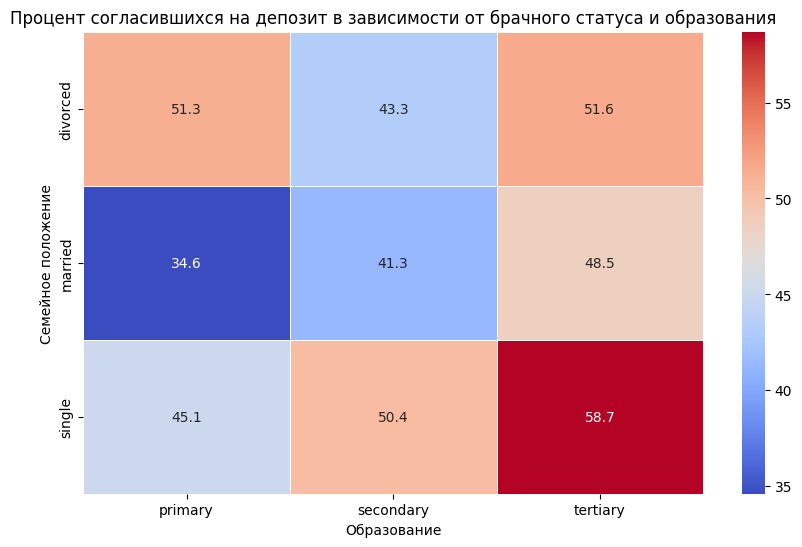

In [22]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Строим кросс-таблицу (пересечение категорий + доля сделавших депозит)
cross_tab = pd.crosstab(index=df_copy['marital'], 
                        columns=df_copy['education'], 
                        values=df_copy['deposit'].map({'yes': 1, 'no': 0}), 
                        aggfunc='mean') * 100  # Переводим в проценты

# Визуализируем таблицу
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title('Процент согласившихся на депозит в зависимости от брачного статуса и образования')
plt.xlabel('Образование')
plt.ylabel('Семейное положение')
plt.show()


In [23]:
# Таблица пересечения категорий marital и education
cross_tab_counts = pd.crosstab(df_copy['marital'], df_copy['education'])

# Выведем таблицу
print(cross_tab_counts)

# Найдём самое большое пересечение
max_category = cross_tab_counts.stack().idxmax()
max_value = cross_tab_counts.max().max()

print(f'Самая многочисленная группа: {max_category} с {max_value} людьми')


education  primary  secondary  tertiary
marital                                
divorced       187        653       337
married        980       3119      1616
single         182       1745      1286
Самая многочисленная группа: ('married', 'secondary') с 3119 людьми


## Часть 3: преобразование данных

In [ ]:
encoder = LabelEncoder()

# Обучение и преобразование
df_copy['education'] = encoder.fit_transform(df_copy['education'])

df_copy['education'] .value_counts()

education
1    5517
2    3239
0    1349
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df_copy[['housing', 'loan', 'deposit', 'default']] = encoder.fit_transform(df_copy[['housing', 'loan', 'deposit', 'default']])
df_copy[['housing', 'loan', 'deposit', 'default']].head()

df_copy['deposit'].std()
df_copy[['housing', 'loan', 'default']].mean().sum()

0.6354280059376547

In [ ]:
df_dummy = pd.get_dummies(df_copy, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=True)
df_dummy.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0.0,2343.0,1.0,0.0,5,1042,1,-1,...,False,False,False,True,False,False,False,False,False,True
1,56,1,0.0,45.0,0.0,0.0,5,1467,1,-1,...,False,False,False,True,False,False,False,False,False,True
2,41,1,0.0,1270.0,1.0,0.0,5,1389,1,-1,...,False,False,False,True,False,False,False,False,False,True
3,55,1,0.0,2476.0,1.0,0.0,5,579,1,-1,...,False,False,False,True,False,False,False,False,False,True
4,54,2,0.0,184.0,0.0,0.0,5,673,2,-1,...,False,False,False,True,False,False,False,False,False,True


In [27]:
# Если целевая переменная в строковом формате, преобразуем в 0 и 1
df_copy = df_dummy.copy()
# Преобразуем 'deposit' в числовой формат, если еще не сделали
# Преобразуем bool в int (0 и 1)
df_copy_int = df_copy.astype(int)

# Вычисляем корреляцию
correlation_with_target = df_copy_int.corr()['deposit'].sort_values(ascending=False)

# Выводим топ-3 коррелирующих признаков
print(correlation_with_target.head(5))  # Первый — сам таргет (1.0), его можно игнорировать




deposit             1.000000
duration            0.457818
poutcome_success    0.288491
pdays               0.147917
previous            0.141102
Name: deposit, dtype: float64


In [ ]:
# разделим датафрейм на целевой и предикты
X = df_copy.drop(['deposit'], axis=1)
y = df_copy['deposit']
# разделим датафрейм на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер тестовой выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер тестовой выборки X_train=(6770, 39), y_train=6770
Размер тестовой выборки X_test=(3335, 39), y_test=3335


In [ ]:
y_test.mean()

0.46326836581709147

In [ ]:
selector = SelectKBest(score_func=f_classif, k=15)  # Создаём объект
X_new = selector.fit_transform(X_train, y_train)  # Применяем отбор

# Получаем отобранные признаки
selected_features = X_train.columns[selector.get_support()]
print(selected_features)

for i in ['month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan']:
    if i not in selected_features:
        print(i)

Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'job_student', 'contact_unknown', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')
month_jan


In [31]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_train

,balance,housing,loan,duration,campaign,pdays,previous,job_student,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
7287,557.0,1.0,0.0,513,1,-1,0,False,False,False,False,False,False,False,True
4766,69.0,0.0,1.0,296,1,205,2,False,False,False,False,False,False,False,False
5712,0.0,1.0,0.0,399,2,358,5,False,False,False,True,False,False,False,False
2530,444.0,0.0,0.0,137,1,102,5,True,False,False,False,False,False,True,False
9294,1444.0,0.0,0.0,100,1,117,8,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,222.0,0.0,1.0,111,1,204,2,False,False,False,False,False,False,False,False
1056,1777.0,1.0,0.0,796,5,154,1,False,False,False,False,False,False,False,False
2931,3324.0,0.0,0.0,122,1,92,3,False,False,False,False,False,False,True,False
7735,209.0,0.0,0.0,605,2,-1,0,False,False,False,False,False,False,False,True


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_test = scaler.transform(X_test)
scaled_x_test.shape
scaled_x_test[:, 0].mean()

0.46823674223097866

In [33]:
scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)
X_test_scal.mean()

balance             0.468237
housing             0.484858
loan                0.131934
duration            0.093294
campaign            0.036153
pdays               0.062139
previous            0.014501
job_student         0.032384
contact_unknown     0.209295
month_mar           0.023688
month_may           0.251574
month_oct           0.031484
month_sep           0.029385
poutcome_success    0.097451
poutcome_unknown    0.743928
dtype: float64

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [ ]:
# Будет использовано как baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_logreg = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
model_logreg.fit(scaled_x_train, y_train)

y_pred_train = model_logreg.predict(scaled_x_train)
y_pred = model_logreg.predict(scaled_x_test)

print(f'Train Accuracy: {accuracy_score(y_pred_train, y_train)}')
print(f'Test Accuracy: {accuracy_score(y_pred, y_test)}')


Train Accuracy: 0.8239290989660266
Test Accuracy: 0.8053973013493253


In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

test_acc_max = -1  
best_depth = None
best_model = None

for depth in range(1, 50):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=42, criterion='entropy')
    model_tree.fit(X_train_scal, y_train)

    y_pred_test = model_tree.predict(X_test_scal)
    test_acc = accuracy_score(y_test, y_pred_test)

    if test_acc > test_acc_max:
        test_acc_max = test_acc
        best_depth = depth
        best_model = model_tree  # Сохраняем модель с лучшим результатом

print(f'Лучшее max_depth: {best_depth}')
print(f'Лучшая точность на тесте: {test_acc_max:.4f}')

# Вычисляем accuracy на обучающей выборке для лучшей модели
y_pred_train = best_model.predict(scaled_x_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}')


Лучшее max_depth: 10
Лучшая точность на тесте: 0.8045
Train Accuracy: 0.8561


In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, criterion='entropy'),
                           param_grid=param_grid,
                           n_jobs=1,
                           scoring='f1')

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models: {grid_search.best_estimator_}')
print(f'Best score: {grid_search.best_score_:.2f}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models: DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score: 0.79


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model_ranfor = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, criterion='gini', random_state=42)
model_ranfor.fit(scaled_x_train, y_train)

y_pred = model_ranfor.predict(scaled_x_test)
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      1723
         1.0       0.84      0.81      0.82      1612

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [ ]:

from sklearn.ensemble import GradientBoostingClassifier

model_grad_boost = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
model_grad_boost.fit(X_train_scal, y_train)

y_pred = model_grad_boost.predict(scaled_x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84      1735
         1.0       0.83      0.80      0.82      1600

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [ ]:

from sklearn.ensemble import StackingClassifier

final_log_reg = LogisticRegression(random_state=42)
estimators = [('lr', model_logreg), ('dt', model_tree), ('ranfor', model_ranfor), ('grboost', model_grad_boost)]
model_stack = StackingClassifier(estimators=estimators,
    final_estimator=final_log_reg)

model_stack.fit(scaled_x_train, y_train)
y_pred = model_stack.predict(scaled_x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1775
         1.0       0.82      0.81      0.82      1560

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [ ]:

imp = model_grad_boost.feature_importances_
names = model_grad_boost.feature_names_in_

look = pd.DataFrame({'Название': names, 'Важность': imp})
look = look.sort_values(by='Важность', ascending=False)
display(look)

,Название,Важность
3,duration,0.512996
13,poutcome_success,0.117808
8,contact_unknown,0.079413
0,balance,0.061744
5,pdays,0.055392
1,housing,0.049387
9,month_mar,0.027306
11,month_oct,0.018960
4,campaign,0.017227
12,month_sep,0.015689


In [ ]:

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Функция для оптимизации
def objective(trial):
    # Подбор параметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем и обучаем модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    model.fit(scaled_x_train, y_train)

    # Оцениваем на тестовой выборке
    y_pred = model.predict(scaled_x_test)
    return f1_score(y_test, y_pred)

# Запускаем оптимизацию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Выводим лучшие параметры и F1-score на тестовой выборке
best_params = study.best_params
best_f1 = study.best_value
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая F1-метрика на тесте: {best_f1:.4f}")


[I 2025-02-21 17:52:08,830] A new study created in memory with name: no-name-4088c698-bbc9-4e30-8557-17c823f7100d
[I 2025-02-21 17:52:09,056] Trial 0 finished with value: 0.8171156893819335 and parameters: {'n_estimators': 126, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8171156893819335.
[I 2025-02-21 17:52:09,317] Trial 1 finished with value: 0.8165717900063251 and parameters: {'n_estimators': 159, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8171156893819335.
[I 2025-02-21 17:52:09,549] Trial 2 finished with value: 0.8176060797973401 and parameters: {'n_estimators': 139, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8176060797973401.
[I 2025-02-21 17:52:09,811] Trial 3 finished with value: 0.8203347016103568 and parameters: {'n_estimators': 156, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8203347016103568.
[I 2025-02-21 17:52:10,107] Trial 4 finished with value: 0.812381554011370

Лучшие параметры: {'n_estimators': 131, 'max_depth': 14, 'min_samples_leaf': 2}
Лучшая F1-метрика на тесте: 0.8269


In [104]:
from sklearn.metrics import accuracy_score

# Обучаем модель с лучшими параметрами
best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_model.fit(scaled_x_train, y_train)

# Делаем предсказания
y_pred = best_model.predict(scaled_x_test)

# Считаем accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовой выборке: {accuracy:.4f}")


Accuracy на тестовой выборке: 0.8354
